In [1]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import ExifTags

In [9]:
from PIL import Image
import os

input_size = (224, 224)

# Path to your dataset folders (normal, dislocation, fractured)
dataset_path = 'D:/DOWNLOADS/DDD'

# Path to save resized and converted RGB images
output_path = 'D:/FDT'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        # Check if the file is an image based on its extension
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp','.kytjpg')):
            image_path = os.path.join(root, filename)
            img = Image.open(image_path).convert("RGB")  # Convert to RGB format
            img = img.resize(input_size, Image.LANCZOS)  # Resize using Lanczos
            # Create subdirectories if they don't exist in the output directory
            output_subdir = os.path.join(output_path, os.path.relpath(root, dataset_path))
            os.makedirs(output_subdir, exist_ok=True)
            img.save(os.path.join(output_subdir, filename))


In [11]:
base_dir = 'D:/SDT'
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

In [12]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


In [13]:
import random
import shutil

for class_name in os.listdir('D:/FDT'):
    class_path = os.path.join('D:/FDT', class_name)
    images = os.listdir(class_path)
    num_images = len(images)
    random.shuffle(images)

    train_split = int(train_ratio * num_images)
    val_split = int(val_ratio * num_images)

    # Copy images to the corresponding split directories
    for i, image in enumerate(images):
        src_path = os.path.join(class_path, image)
        if i < train_split:
            dst_dir = os.path.join(base_dir, 'train', class_name)
        elif i < train_split + val_split:
            dst_dir = os.path.join(base_dir, 'val', class_name)
        else:
            dst_dir = os.path.join(base_dir, 'test', class_name)
        
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, os.path.join(dst_dir, image))


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 10

train_generator = train_datagen.flow_from_directory(
    'D:/SDT/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'D:/SDT/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'D:/SDT/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1392 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


In [3]:
%%writefile cspine.py
import streamlit as st
import tensorflow as tf
from PIL import Image, ImageOps
from PIL import ExifTags
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt

# Function to load the model

def load_model():
    model = tf.keras.models.load_model('D:/MAJOR P/t1.hdf5')
    return model

# Load the model
with st.spinner('Model is being loaded..'):
    model = load_model()

st.write("""
         # Cervical Spine Image Classification
         """
         )

file = st.file_uploader("Please upload a cervical spine image (jpg or png)", type=[".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp",".kytjpg"])

st.set_option('deprecation.showfileUploaderEncoding', False)

def import_and_predict(image_data, model):
    # Resize the image to match the model's input size (224x224)
    input_size = (224, 224)
    image = ImageOps.fit(image_data, input_size, Image.LANCZOS)
    image = image.convert("RGB")  # Ensure the image is in RGB format
    image = img_to_array(image)
    image = preprocess_input(image)

    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    prediction = model.predict(image)

    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    
    # Make predictions
    predictions = import_and_predict(image, model)
    
    predicted_class = np.argmax(predictions, axis=1)
    class_labels = ['Dislocation', 'Fracture', 'Normal']  # Replace with your actual class labels
    class_label = class_labels[predicted_class[0]]
    probability = predictions[0][predicted_class[0]]
    
    st.write("Prediction:", class_label)
    st.write("Confidence:", probability * 100, "%")


Overwriting cspine.py


In [2]:
!ngrok authtoken 2WGeeZBVnXLxsorjmjxm5470s6A_2Bcms3uvRpAFUh97c45DN

Authtoken saved to configuration file: C:\Users\swapn\AppData\Local/ngrok/ngrok.yml


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify input shape and number of classes
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 3  # Adjust for your classification task

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Create your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer and a specific learning rate
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])


# Train your model with your dataset
# model.fit(train_generator, epochs=epochs, validation_data=val_generator)
model.fit(train_generator, epochs=30, batch_size=10, validation_data=validation_generator)
# Make sure to load your dataset and train the model with the appropriate data and labels.
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/30
140/140 [==============================] - 74s 490ms/step - loss: 0.5500 - accuracy: 0.7716 - val_loss: 0.1005 - val_accuracy: 0.9966
Epoch 2/30
140/140 [==============================] - 68s 485ms/step - loss: 0.0931 - accuracy: 0.9784 - val_loss: 0.0356 - val_accuracy: 0.9966
Epoch 3/30
140/140 [==============================] - 71s 505ms/step - loss: 0.0588 - accuracy: 0.9871 - val_loss: 0.0784 - val_accuracy: 0.9933
Epoch 4/30
140/140 [==============================] - 67s 482ms/step - loss: 0.0455 - accuracy: 0.9899 - val_loss: 0.0346 - val_accuracy: 0.9966
Epoch 5/30
140/140 [==============================] - 70s 499ms/step - loss: 0.0499 - accuracy: 0.9914 - val_loss: 0.0345 - val_accuracy: 0.9966
Epoch 6/30
140/140 [==============================] - 72s 514ms/step - loss: 0.0303 - accuracy: 0.9928 - val_loss: 0.0482 - val_accuracy: 0.9899
Epoch 7/30
140/140 [==============================] - 71s 507ms/step - loss: 0.0403 - accuracy: 0.9914 - val_loss: 0.0218 - val_ac

In [6]:
tf.keras.models.save_model(model,'t1.hdf5')

C:\Users\swapn\AppData\Local\Temp\ipykernel_13424\2951956335.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'t1.hdf5')


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


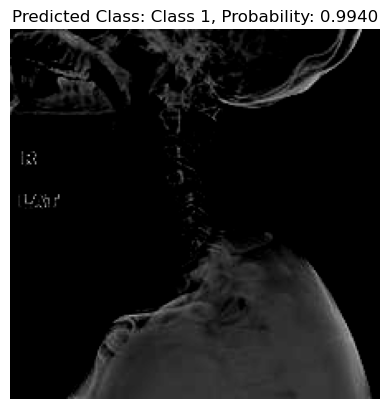

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image  # Import the Image module
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model('t1.hdf5')

image_path = 'D:/SDT/test/c-spine_dis/GWARA_1.2.156.112536.2.560.144226186176121069.1318463587854. (19th copy).JPG'
input_size = (224, 224)  # Adjust the target size to match your model's input shape
image = Image.open(image_path).convert("RGB")
image = image.resize(input_size, Image.LANCZOS)
image = img_to_array(image)
image = preprocess_input(image)

image = np.expand_dims(image, axis=0)  # Add a batch dimension
predictions = model.predict(image)




# Assuming your model predicts 3 classes
predicted_class = np.argmax(predictions, axis=1)
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels
class_label = class_labels[predicted_class[0]]
probability = predictions[0][predicted_class[0]]

plt.imshow(image[0])
plt.title(f'Predicted Class: {class_label}, Probability: {probability:.4f}')
plt.axis('off')
plt.show()


In [ ]:
def import_and_predict(image_data, model):
    # Resize the image to match the model's input size (224x224)
    input_size = (224, 224)
    image = ImageOps.fit(image_data, input_size, Image.LANCZOS)
    image = image.convert("RGB")  # Ensure the image is in RGB format
    image = img_to_array(image)
    image = preprocess_input(image)

    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    prediction = model.predict(image)

    return prediction

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('D:/MAJOR P/t1.hdf5')  # Replace with your model path

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [6]:
last_conv_layer

In [11]:
pip install --user opencv-python-headless


  Using cached opencv_python_headless-4.8.1.78-cp37-abi3-win_amd64.whl (38.0 MB)
Note: you may need to restart the kernel to use updated packages.
